Jupyter notebook to test out fresnel lens PSFs

In [14]:
# Import libraries
import os
import argparse
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat, savemat
import propagation as prop
import utils

Set hyperparameters and global variables

In [15]:
# Mask-related parameters; all units in microns (um)
FOCAL_LENGTH    = 2000
WAVELENGTH      = 0.532
MASK_DIAMETER   = 1000 
MASK_SIZE       = 1200
MASK_PITCH      = 1
CIRCULAR_MASK   = True

In [16]:
# set up mask-related variables and coordinate system
L = MASK_SIZE; dxy = MASK_PITCH
x = np.arange(-1*L/2 + dxy/2, 1*L/2 , dxy)
y = np.arange(-1*L/2 + dxy/2, 1*L/2 , dxy)
[X, Y] = np.meshgrid(x, y)

Create fresnel lens phase profile. Basically says that given any light of any wavelength, this is the amplitude and phase that we are going to add to it. This ensures that (focal_length * wavelength) = constant

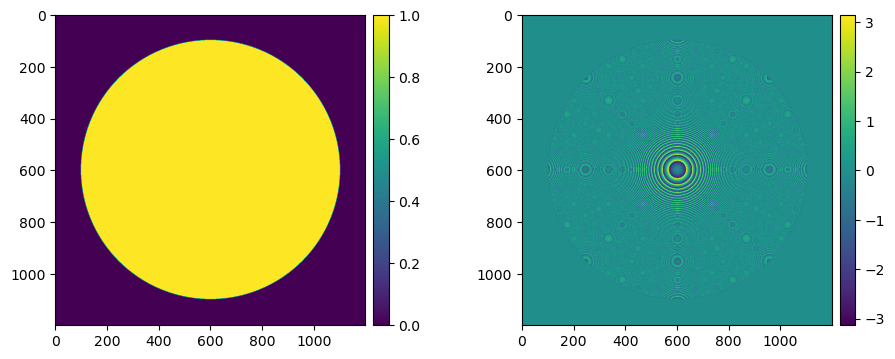

In [17]:
D = MASK_DIAMETER; lmb = WAVELENGTH; F = FOCAL_LENGTH
phase = (-2*np.pi/lmb)*(X**2+Y**2)/(2*F)
H = 1 * np.exp(1j*phase)
if CIRCULAR_MASK:
    H[np.where((X**2 + Y**2)>=(D**2)/4)] = 0
else:
    H[np.where(np.abs(X)>D/2)] = 0
    H[np.where(np.abs(Y)>D/2)] = 0

# plot binary phase mask
plt.figure(figsize=(10,7))
ax1 = plt.subplot(121); im1 = ax1.imshow(np.abs(H)); utils.add_colorbar(im1) 
ax2 = plt.subplot(122); im2 = ax2.imshow(np.angle(H)); utils.add_colorbar(im2) 
plt.subplots_adjust(left=0.1,bottom=0.1,right=0.9,top=0.9,wspace=0.4,hspace=0)
plt.show()

Simulate PSFs for different depths

In [18]:
# imaging related parameters (all units in microns)
u_start = -2000
u_end   = +2000
u_focus = 4000
v       = 4000
LMBDS   = [0.450, 0.530, 0.610] # Wavelengths for which we want to render PSFs 
NUM_Z   = 15

PSF_ROI = 100               # in microns, NOT pixels
pt_src_x = 0; pt_src_y = 0  # Point source location 

u_delta = (u_end-u_start)/(NUM_Z-1)
u_vals = u_focus + np.arange(u_start, u_end + u_delta, u_delta)
Nz = len(u_vals)
Nl = len(LMBDS)
psfstack = np.zeros((int(PSF_ROI/dxy),int(PSF_ROI/dxy),Nz,Nl))
print("Simulating PSFs at:")
for i in range(Nz):
    u = u_vals[i]
    print("{:3.3f}".format(u), end=',')
    for j in range(Nl):
        lmbd = LMBDS[j]
        # u_ptsrc = prop.prop2d_as(np.exp(1j*phase1), [L, L], lmbd, u_focus)
        u_ptsrc = 1 * np.exp(1j*(2*np.pi/lmbd)* np.sqrt((X-pt_src_x)**2 + (Y-pt_src_y)**2 + u**2 ))
        u_out = prop.prop2d_as(u_ptsrc*H, [L, L], lmbd, v)
        u_out = np.abs(u_out)**2
        u_out = u_out[int(L/(2*dxy))-int(PSF_ROI/(2*dxy)):int(L/(2*dxy))+int(PSF_ROI/(2*dxy)), 
                        int(L/(2*dxy))-int(PSF_ROI/(2*dxy)):int(L/(2*dxy))+int(PSF_ROI/(2*dxy))]
        psfstack[:,:,i,j] = u_out

print("\nAiry-disk EDOF limit: {:3.3f}".format(4*lmb*F*F/(D*D)))

Simulating PSFs at:
2000.000,2285.714,2571.429,2857.143,3142.857,3428.571,3714.286,4000.000,4285.714,4571.429,4857.143,5142.857,5428.571,5714.286,6000.000,6285.714,
Airy-disk EDOF limit: 8.512


Plot PSFs for different depths

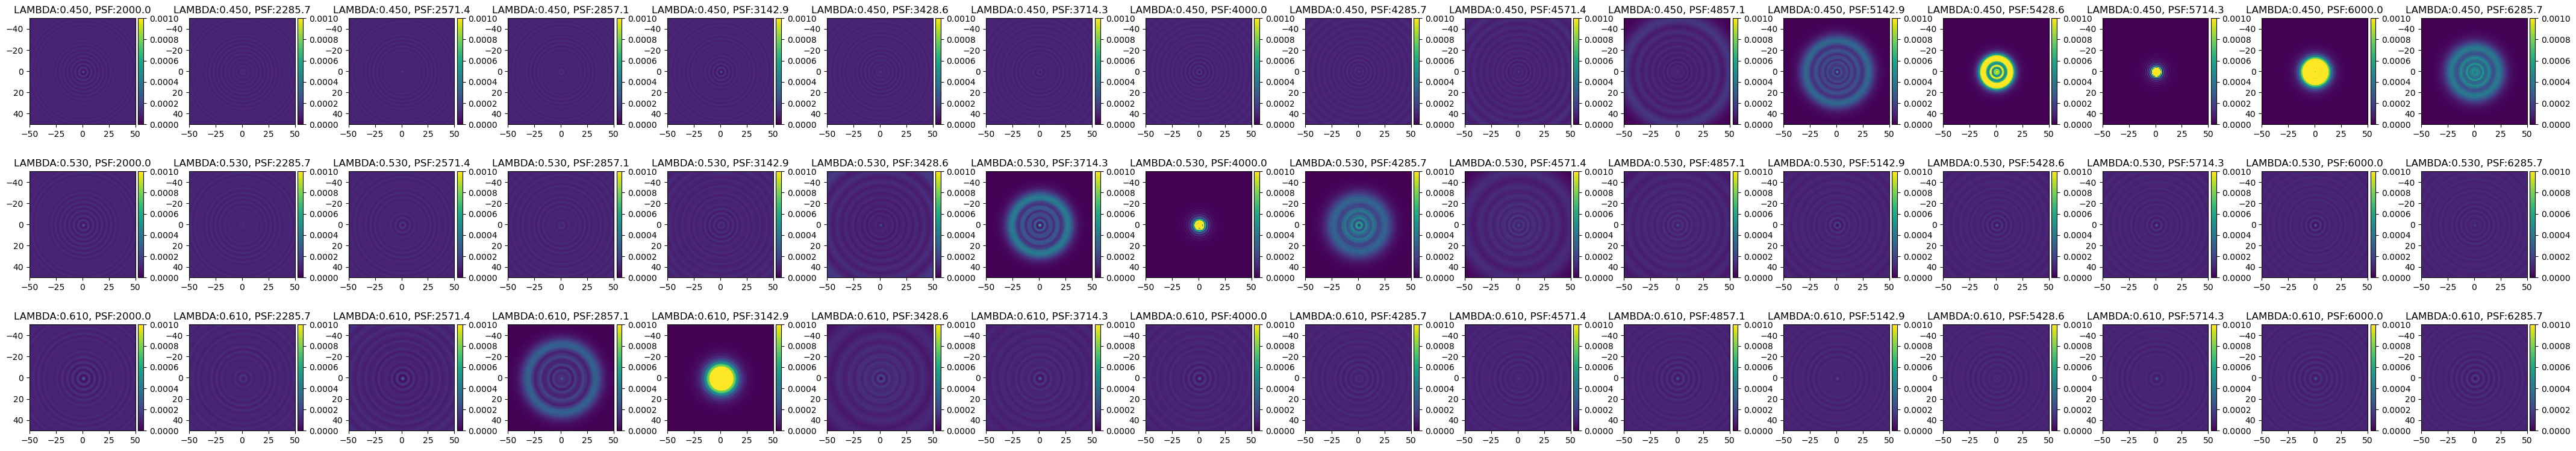

In [19]:
COLS = Nz
ROWS = Nl
fig = plt.figure(figsize=(4 + 3*Nz, 3*Nl))
# fig = plt.figure(figsize=(25, 9))
ax1 = []
k=0
for j in range(ROWS):
    for i in range(COLS):
        psf = psfstack[:,:,i,j]
        psf = psf/np.sum(psf)
        ax1.append( fig.add_subplot(ROWS, COLS, k+1) )
        ax1[-1].set_title("LAMBDA:{:.3f}, PSF:{:4.1f}".format(LMBDS[j], u_vals[i]))  # set title
        im1 = ax1[-1].imshow(psf, vmin=0, vmax=0.001, extent=[-(PSF_ROI/(2*1)),(PSF_ROI/(2*1)),(PSF_ROI/(2*1)),-(PSF_ROI/(2*1))])
        utils.add_colorbar(im1)
        k = k+1
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.2)

# fig = plt.figure(figsize=(20,10))
# ax = plt.gca()
# im = ax.imshow(np.squeeze(psfstack[:,int(PSF_ROI//(2*dxy)),:]), extent=[u_focus+u_start,u_focus+u_end,-(PSF_ROI/(2*1)),(PSF_ROI/(2*1))])
# utils.add_colorbar(im, pad_fraction=0.9)
# ax.set_title('XZ MIP')